In [1]:
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For prediction
from tqdm import tqdm

from extract_zip import extract_zip_to_memory # function for decompressing zip in memory
from PIL import Image, ImageOps # image handling


# for the CNN
import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential

from sklearn import preprocessing

basepath = "/mnt/datasets/plankton/flowcam/"

Using TensorFlow backend.


In [2]:
img_files = extract_zip_to_memory(basepath + "imgs.zip")

In [3]:
img_files_keys = img_files.keys()
print(len(img_files_keys))
list(img_files_keys)[:5]

243610


['imgs/32704266.jpg',
 'imgs/32759087.jpg',
 'imgs/32677400.jpg',
 'imgs/32643733.jpg',
 'imgs/32593109.jpg']

In [4]:
# dataset
nativeDF = pd.read_csv(basepath + 'features_native.csv.gz')
skimagDF = pd.read_csv(basepath + 'features_skimage.csv.gz')
labelsDF = pd.read_csv(basepath + 'meta.csv')

In [5]:
print(nativeDF.isnull().sum().sort_values(ascending=False)[:10])
print(skimagDF.isnull().sum().sort_values(ascending=False)[:6])

native_nan_cols = ['perimareaexc', 'feretareaexc', 'cdexc', 'skeleton_area',
                   'nb1_area', 'symetrieh_area', 'symetriev_area', 'convarea_area',
                  'nb2_area', 'nb3_area', ]
skimage_nan_cols = ['moments_normalized4', 'weighted_moments_normalized0', 
                    'moments_normalized1', 'moments_normalized0',
                   'weighted_moments_normalized1', 'weighted_moments_normalized4']

perimareaexc      34428
feretareaexc      34428
cdexc             34428
skeleton_area      6854
nb1_area           6854
symetrieh_area     6854
symetriev_area     6854
convarea_area      6854
nb2_area           6854
nb3_area           6854
dtype: int64
moments_normalized4             243610
weighted_moments_normalized0    243610
moments_normalized1             243610
moments_normalized0             243610
weighted_moments_normalized1    243610
weighted_moments_normalized4    243610
dtype: int64


In [6]:
for col_name in native_nan_cols:
    nativeDF[col_name] = nativeDF[col_name].fillna(0)

for col_name in skimage_nan_cols:
    skimagDF[col_name] = skimagDF[col_name].fillna(0)

labelsDF['objid'] = labelsDF['objid'].astype(np.int64, errors='ignore')
labelsDF['level1'] = labelsDF['level1'].fillna('No level1 name')
labelsDF['level2'] = labelsDF['level2'].fillna('No level2 name')

print(nativeDF.isnull().sum().any())
print(skimagDF.isnull().sum().any())
print(labelsDF.isnull().sum().any())

False
False
False


In [7]:
print('Nr. of unique level1 names')
print(labelsDF['level1'].nunique())
print('Nr. of unique level2 names')
print(labelsDF['level2'].nunique())
print('Nr. of unique names')
print(labelsDF['unique_name'].nunique())

Nr. of unique level1 names
57
Nr. of unique level2 names
40
Nr. of unique names
103


In [8]:
number_unique_names = labelsDF.groupby('level2', as_index=True)['id'].count()
number_unique_names.sort_values(inplace=True, ascending=False)

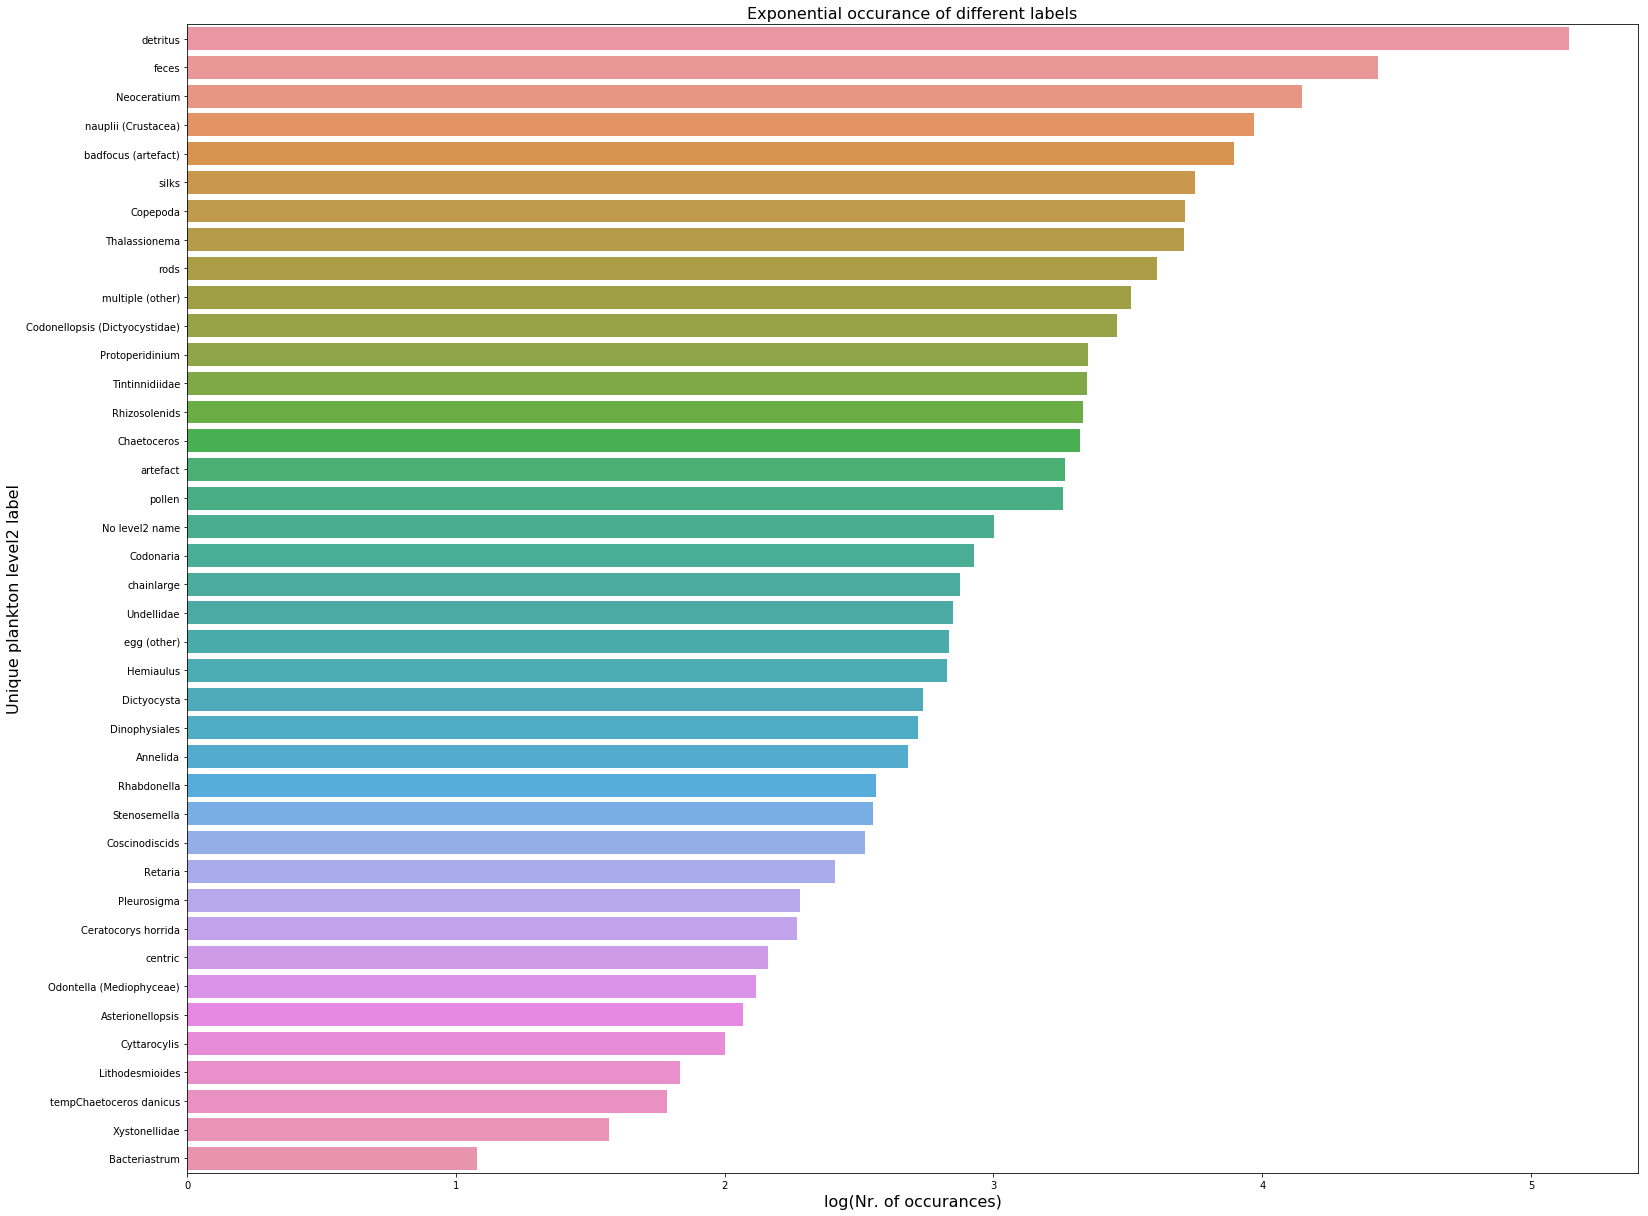

In [9]:
figure, ax = plt.subplots(figsize=(23,17))
ax = sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values))


plt.ylabel('Unique plankton level2 label', fontsize= 16)
plt.xlabel('log(Nr. of occurances)', fontsize= 16)
plt.title('Exponential occurance of different labels', fontsize=16)
plt.tight_layout()

### Functions used for the autoloader and preprocessing

In [10]:
# code inspired by https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/

def image_processing(path):
    desired_size = 972 # max of width and height in dataset
    im_orginal = Image.open(path)
    old_size = im_orginal.size  # old_size[0] is in (width, height) format
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im_scaled = im_orginal.resize(new_size) # scale up picture before padding to keep information
    
    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    im_padded = ImageOps.expand(im_scaled, padding, fill=255) # padding of scaled picture
    
    final_size = (100, 100) # input size for CNN
    im_final = im_padded.resize(final_size, resample=0) # resize to input size of CNN
    return np.array(im_final)
    
def autoloader(list_of_keys):
    return np.array([image_processing(img_files[key]) for key in list_of_keys])
    

def key_to_objid(list_of_keys):
    def strip(key):
        return int(key[5:-4])
    return [strip(key) for key in list_of_keys]

def fetch_labels(list_of_keys, lvl='level2'):
    list_of_objid = key_to_objid(list_of_keys)
    labels = []
    for objid in list_of_objid:
        label = list(labelsDF[labelsDF['objid']==objid][lvl])
        labels.append(label[0])
    return labels


### Dividing data into test and training

In [11]:
img_files_keys = list(img_files.keys())

# Divide data into training and test data, by keys
from sklearn.model_selection import train_test_split


seed = 1
test_size = 0.10
keys_train, keys_test = train_test_split(img_files_keys, test_size = test_size, random_state = seed)

# Make small test and validation set, to explore models. 
size_small_test, size_small_validation = 50000, 5000
small_keys_train = keys_train[:size_small_test]
small_keys_validation = keys_train[:size_small_validation]

# Fetch pictures and labels, corresponding to keys.
# train
X_train = autoloader(small_keys_train)
y_train = fetch_labels(small_keys_train)
# test
X_test = autoloader(small_keys_validation)
y_test = fetch_labels(small_keys_validation)

np_ytrain = np.array(y_train)
np_ytrain = np.unique(np_ytrain)

np_ytest = np.array(y_test)
np_ytest = np.unique(np_ytest)
print(np_ytrain.size, np_ytest.size)

39 39


In [12]:
# We want to label-encode the different categories so we can one-hot encode them.  
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# label encode target column
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape input data to account for images only being greyscale
X_train = X_train.reshape(size_small_test, 100, 100, 1)
X_test = X_test.reshape(size_small_validation, 100, 100, 1)

### Parameters for keras CNN

In [13]:
# input dimensions
input_shape = (100, 100, 1)
# network parameters 
batch_size = 128
classes = labelsDF.level2.unique()
num_classes = labelsDF.level2.nunique()
epochs = 3 # Further Fine Tuning can be done


### Architectures
 
- input -> (conv -> pool)*2 -> fc -> softmax
- input -> (conv -> conv -> pool)*3-4 -> fc -> fc -> softmax

#### To further explore
Data augementation of pictures with rare labels
- https://medium.com/@arindambaidya168/https-medium-com-arindambaidya168-using-keras-imagedatagenerator-b94a87cdefad
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [60]:
# Keras CNN model
model = Sequential()

# add first  layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add second layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

# add flatten layer
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

# add last layer
model.add(Dense(num_classes, activation='softmax'))

# complile the model and view its architecur
model.compile(loss=keras.losses.categorical_crossentropy,  optimizer="Adam", metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 33856)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                2166848   
__________

In [61]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test))

ValueError: Error when checking target: expected dense_22 to have shape (40,) but got array with shape (37,)

In [ ]:
'''# Keras CNN model
model = Sequential()


# add first convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

# add second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# add one max pooling layer 
model.add(MaxPooling2D(pool_size=(2, 2)))

# add one dropout layer
model.add(Dropout(0.25))

# add flatten layer
model.add(Flatten())

# add dense layer
model.add(Dense(128, activation='relu'))

# add another dropout layer
model.add(Dropout(0.5))

# add dense layer
model.add(Dense(num_classes, activation='softmax'))

# complile the model and view its architecur
model.compile(loss=keras.losses.categorical_crossentropy,  optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

model.summary()'''